##Class Activation Maps with Fashion MNIST

Implement a simple class activation map (CAM) of a model trained on the Fashion MNIST dataset
* The CAM will show what parts of the image the model was paying attention to when deciding the class of the image 

In [2]:
##Imports 

import keras
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model 
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
import scipy as sp

##Download and Prep the Data

In [3]:
#Load the Fashion MNIST Dataset
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [4]:
len(X_train), len(X_test)

(60000, 10000)

Put an additional axis for the channels of the image

Fashion MNIST is grayscale so palce a `1` at the end (other datasets would need `3` of they are RGB)

In [5]:
X_train = X_train.reshape(len(X_train), 28, 28, 1)
X_test = X_test.reshape(len(X_test), 28, 28, 1)

Normalize the pizel values from 0 to 1

In [7]:
X_train = X_train / 255
X_test = X_test / 255

#Cast to float
X_train = X_train.astype('float')
X_test = X_test.astype('float')

##Utilities

In [11]:
def show_img(img):
  """
  Reshapes and displays an image 
  """

  #Convert to float array if img is not yet preprocessed 
  img = np.array(img, dtype='float')

  #Remove channel dimensions 
  img = img.reshape((28,28))

  #Display image
  plt.imshow(img)

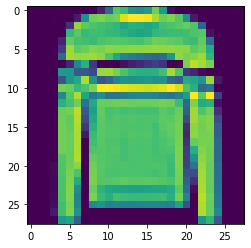

In [12]:
#Function test
show_img(X_train[5])

##Build the Classifier 

##Define the Model 

The image will go through four convolutions each followed by a pooling layer

The final Dense layer will output the probabilities for each class

In [13]:
#Use the Sequential API to make things easier 
model = Sequential()

#Notice that the padding parameter to recover the lost border pixels when doing the convolution 
model.add(Conv2D(16, input_shape=(28,28,1), kernel_size=(3,3), activation='relu', padding='same'))
#Pooling layer with a stride of 2 will reduce the image dimensions by half 
model.add(MaxPooling2D(pool_size=(2,2)))

#Pass through three more convolutions / poolings with each increasing the filters 
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Last convolution doesn't have MaxPooling
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))

#Use GlobalAveragePooling to take into account lesser intensity pixels 
model.add(GlobalAveragePooling2D())

#Ouput the class probabilities 
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

In [14]:
##Train the Model 
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#Train the model 
model.fit(X_train, Y_train,
          batch_size=32,
          epochs=5,
          validation_split=0.1,
          shuffle=True)

Epoch 1/5
1688/1688 [==============================] - 67s 39ms/step - loss: 2.3027 - accuracy: 0.0993 - val_loss: 2.3027 - val_accuracy: 0.0925
Epoch 2/5
1688/1688 [==============================] - 74s 44ms/step - loss: 2.3028 - accuracy: 0.0973 - val_loss: 2.3030 - val_accuracy: 0.0942
Epoch 3/5
1688/1688 [==============================] - 77s 46ms/step - loss: 2.3028 - accuracy: 0.0981 - val_loss: 2.3029 - val_accuracy: 0.0942
Epoch 4/5
1688/1688 [==============================] - 68s 40ms/step - loss: 2.3028 - accuracy: 0.0986 - val_loss: 2.3031 - val_accuracy: 0.0925
Epoch 5/5
1688/1688 [==============================] - 59s 35ms/step - loss: 2.3028 - accuracy: 0.0985 - val_loss: 2.3031 - val_accuracy: 0.0985


##Generate the CAM

To generate the class activation map, get the features detected in the last convolution layer and see which ones are most active when generating the output probabilities

In [15]:
#First convolution layer 
print(model.layers[-3].name)

#Global average pooling layer
print(model.layers[-2].name)

#Output of the classifier 
print(model.layers[-1].name)

conv2d_3
global_average_pooling2d
dense


Create the CAM model 

In [16]:
#Same as previous model but with an additional output 
cam_model = Model(inputs=model.input, outputs=[model.layers[-3].output,
                                               model.layers[-1].output])

Use the CAM model to predict on the test set so that it generates the features and the predicted probability for each class (`results`)

In [18]:
#get the features and results of the test images using the newly created model 
features, results = cam_model.predict(X_test)

#Shape of features 
print('features shape: ', features.shape, '\n\nResults shape: ', results.shape)

features shape:  (10000, 3, 3, 128) 

Results shape:  (10000, 10)


Generate the CAM by getting the dot product of the class activation features and the class activation weights 

Use the weights from the GlobalAveragePooling layer to calculate the activations of each feature given a particular class

* Get the weights from the dense layer that follows the GAP layer  * The last conv2D layer has (h,w,depth) of (3 x 3 x 128), so there are 128 features.
 * The global average pooling layer collapses the h,w,f (3 x 3 x 128) into a dense layer of 128 neurons (1 neuron per feature).
 * The activations from the global average pooling layer get passed to the last dense layer.
 * The last dense layer assigns weights to each of those 128 features (for each of the 10 classes),
 * So the weights of the last dense layer (which immmediately follows the global average pooling layer) are referred to in this context as the "weights of the global average pooling layer".

For each of the 10 classes, there are 128 features each with their own feature weight

In [19]:
#These are the weights going into the softmax layer 
last_dense_layer = model.layers[-1]

#Get the weights list. Index 0 contains the weights, Index 1 contains the biases
gap_weights_list = last_dense_layer.get_weights()

print('gap_weights_list index 0 contains the weights ', gap_weights_list[0].shape)
print('gap_weights_list index 1 contains the biases ', gap_weights_list[1].shape)

gap_weights_list index 0 contains the weights  (128, 10)
gap_weights_list index 1 contains the biases  (10,)


In [20]:
#Show the number of features per class and the total number of classes 
gap_weights = gap_weights_list[0]

print(f'There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes')

There are 128 feature weights and 10 classes


Get the features for a specific image (indexed between 0 and 999)

In [22]:
idx = 883
features_for_img = features[idx, :, :, :]

print(f'the features for img index {idx} has shape (height, width, num of features channels): ', features_for_img.shape)

the features for img index 883 has shape (height, width, num of features channels):  (3, 3, 128)


The features have a height and width of 3x3. Scale them up to the original image height and width of 28x28

In [23]:
features_for_img_scaled = sp.ndimage.zoom(features_for_img, (28/3, 28/3, 1), order=2)

#Check the shape after scaling back to 28x28
print(features_for_img_scaled.shape)

(28, 28, 128)


For a particular class (0 to 9) get the 128 feature weights 
* Take the dot product with the scaled features for the selected image with the weights 
* The shapes are scaled features: (h, w, depth) of (28x28x128)
* The dot product produces the class activation map witht he shape equal to the height and width of the image: 28x28

In [27]:
#Select the weights that are used for a specific class
class_id = 6

#Take the dot product between the sclaed image features and the weights for it 
gap_weight_for_one_class = gap_weights[:, class_id]

print('features_for_img_scaled has shape: ', features_for_img_scaled.shape)
print('gap_weights_for_one_class has shape: ', gap_weight_for_one_class.shape)

#Take the dot product between the scaled features and the weights for one class 
cam = np.dot(features_for_img_scaled, gap_weight_for_one_class)
print('\nclass activation map shape: ', cam.shape)

features_for_img_scaled has shape:  (28, 28, 128)
gap_weights_for_one_class has shape:  (128,)

class activation map shape:  (28, 28)


##Conceptual Interpretation 

* In the 28 x 28 x 128 feature map, each of the 128 feature filters is tailored to look for a specific set of features (for example, a shoelace).
 * The actual features are learned, not selected by you directly.
* Each of the 128 weights for a particular class decide how much weight to give to each of the 128 features, for that class.
 * For instance, for the "shoe" class, it may have a higher weight for the feature filters that look for shoelaces.
* At each of the 28 by 28 pixels, you can take the vector of 128 features and compare them with the vector of 128 weights.
 * You can do this comparison with a dot product.
The dot product results in a scalar value at each pixel.
 * Apply this dot product across all of the 28 x 28 pixels.
 * The scalar result of the dot product will be larger when the image both has the particular feature (e.g. shoelace), and that feature is also weighted more heavily for the particular class (e.g shoe).

So you've created a matrix with the same number of pixels as the image but each value at each pixel is higher when that pixel is relevant to the prediction of a particular class

In [28]:
def show_cam(image_index):
  """Display the class activation map of a particular image"""

  # takes the features of the chosen image
  features_for_img = features[image_index, :, :, :]

  # get the class with the highest output probability
  prediction = np.argmax(results[image_index])

  # get the gap weights and the predicted class (shape 3x3)
  class_activation_weights = gap_weights[:, prediction]

  # upsample the features to the image's original shape (28, 28)
  class_activation_features = sp.ndimage.zoom(features_for_img, (28/3, 28/3, 1), order=2)

  # compute the intesity of each feature in the CAM
  cam_output = np.dot(class_activation_features, class_activation_weights)

  print("Predicted class = "+ str(prediction) + ", Probabilty = " + str(results[image_index][prediction]))

  # show the upsampled image
  plt.imshow(np.squeeze(X_test[image_index], -1), alpha=0.5)

  # strongly classified (95% probability) images will be in green, else red
  if results[image_index][prediction]>0.95:
    cmap_str = "Greens"
  else:
    cmap_str = "Reds"

  # over the cam output
  plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

  # display the image
  plt.show()

In [32]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates CAMs 
    for the first `num_maps`(int) of the `desired_class`(int)
    '''

    counter = 0

    if desired_class > 10:
        print("please choose a class less than 10")

    # go through the first 10000 images
    for i in range(0,10000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i)

##Display the CAM on a num_maps for a given class

Predicted class = 5, Probabilty = 0.10273304


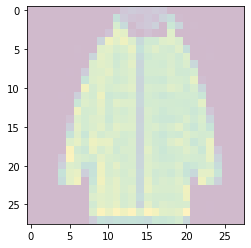

In [37]:
show_maps(desired_class=4, num_maps=2)
show_cam(888)